# <font color="red">  Sign stop detection </font>
we have 100 image each class, so we will create a simple neural to classify each type

In [116]:
import cv2
import numpy as np
from torchvision import transforms 
import torch.nn as nn  
import torch
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import DataLoader,Dataset


In [117]:
valid_extension = ['.jpg','.png','.bmp','.jpeg','.JPG']

from sklearn.model_selection import train_test_split

# Thử kiểu chia này xem có đạt hiệu quả tốt hơn so với train_test_split không
# # initialize a stratified shuffle split object with 80% train and 20% test
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# # get the train and test indices from the split object, stratified by class
# train_idx, test_idx = next(split.split(X, y))

# # get the train and test data and labels based on the indices
# X_train, y_train = X[train_idx], y[train_idx]
# X_test, y_test = X[test_idx], y[test_idx]


def survey(fol_data): # survey about the size of dataset
    valid_num = 0
    max_h = 0
    max_w = 0
    min_h =0
    min_w =0
    average_size = [0,0]
    for fol_name in os.listdir(fol_data):
        path_fol = os.path.join(fol_data,fol_name)
        for file_name in os.listdir(path_fol):
            tmp = os.path.splitext(file_name)[-1]
            if any(tmp in name for name in valid_extension) and tmp != '':
                img = cv2.imread(os.path.join(path_fol,file_name))
                if valid_num == 0 :
                    min_h = img.shape[0]
                    min_w = img.shape[1]
                h,w = img.shape[0:2]
                average_size[0] += h
                average_size[1] += w
                if h > max_h : max_h = h
                if w > max_w : max_w = w
                if h < min_h : min_h = h
                if w < min_w : min_w = w
                valid_num +=1
        average_size = np.array(average_size)
        average_size = average_size/ valid_num
    print(f'average_size of img is (h,w) {average_size}, max_h and max_w is {max_h,max_w}, min_h and min_w is {min_h,min_w}')
# survey("sign_data")

class SignDataset(Dataset): # create a class of data, split data
    def __init__(self,root_dir,train = True,SIZE = 112,test_size = 0.2,seed = 15) -> None:
        
        self.root_dir = root_dir
        self.size = SIZE
        self.image_paths = []
        self.labels = []
        self.positive_lb = 0
        flag = 0
        for foler_name in os.listdir(root_dir): # read all image path and label to array
            folder_path = os.path.join(root_dir,foler_name)
            for filename in os.listdir(folder_path):
                tmp = os.path.splitext(filename)[-1]
                if any(tmp in name for name in valid_extension) and tmp != '': # be sure that file is image
                    self.image_paths.append(os.path.join(folder_path,filename)) # append path file
                    if foler_name == 'stop': # based on folder name to add label
                        self.labels.append(1)
                        self.positive_lb += 1
                    else:
                        self.labels.append(0)
        if self.labels[0] : # specify the flag to slit equal 2 class
            flag = self.positive_lb
        else:
            flag = len(self.labels) - self.positive_lb

        np.random.seed(seed) # make random for each class
        if train:
            self.image_paths, _, self.labels, _ = train_test_split(self.image_paths, self.labels, test_size=test_size, stratify=self.labels)
        else:
            _,self.image_paths,_,self.labels = train_test_split(self.image_paths, self.labels, test_size=test_size, stratify=self.labels)
            
    def __len__(self):
        return len(self.image_paths)
    def statistic(self):
        print(f'This dataset has {self.positive_lb} positive samples (sign) and {len(self.image_paths)-self.positive_lb} negative samples')
    def __getitem__(self,idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')
        composed = transforms.Compose([transforms.Resize((self.size,self.size)),
                                       transforms.ToTensor(), # devide all pixel for 255 then reshape to channel*heigh*width
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # take (Tensor - 0.5)/0.5 with each channel
        image = composed(image)
        return image,label

def pp(img_path,size = 112):
  img = Image.open(img_path).convert('RGB')
  composed = transforms.Compose([transforms.Resize((size,size)),
                                       transforms.ToTensor(), # devide all pixel for 255 then reshape to channel*heigh*width
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # take (Tensor - 0.5)/0.5 with each channel
  img = composed(img)
  img = torch.unsqueeze(img,dim=0)
  return img

def convert_Tensor2tensor(input):
    cn1,cn2,cn3 = input[0:3]
    c,h,w = input.shape[0:3]
    cnnew = torch.zeros((h,w,c))
    cnnew[:,:,0]=cn1
    cnnew[:,:,1]=cn2
    cnnew[:,:,2]=cn3
    return cnnew

def acc_fn(ytrue,yprd):
    correct = torch.eq(ytrue, yprd).sum().item()
    acc = (correct/len(yprd))*100
    return acc

In [118]:
# survey('/content/t_drive/MyDrive/data_hoc_ML/sign_data')

`__get__` giup truy cap vao cac phan tu cua object ma khong can goi ham <br>
Vd: `dataset = CustomData('path_data)`

`dataset[4]` : return image and label of data in index 4

In [119]:
class cnn_sign(nn.Module):
    def __init__(self,filter1 = 8, filter2 = 4) -> None:
        super(cnn_sign,self).__init__()
        self.conv_pine = nn.Sequential(nn.Conv2d(3,filter1,kernel_size = 3, padding  =1),
                                       nn.ReLU(inplace = True),
                                       nn.MaxPool2d(kernel_size=2,stride=2),
                                       
                                       nn.Conv2d(filter1,filter2,kernel_size = 3),
                                       nn.ReLU(inplace =True),
                                       nn. MaxPool2d(kernel_size = 2,stride =2))
        self.clf = nn.Sequential(nn.Linear(filter2*27*27,1),
                                 nn.Sigmoid())
    def forward(self,x):
        x = self.conv_pine(x)
        x = x.view(x.size(0),-1)
        x = self.clf(x)
        return x

In [120]:
model = cnn_sign(12,4).to('cuda')
from torchsummary import summary
summary(model,(3,112,112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 112, 112]             336
              ReLU-2         [-1, 12, 112, 112]               0
         MaxPool2d-3           [-1, 12, 56, 56]               0
            Conv2d-4            [-1, 4, 54, 54]             436
              ReLU-5            [-1, 4, 54, 54]               0
         MaxPool2d-6            [-1, 4, 27, 27]               0
            Linear-7                    [-1, 1]           2,917
           Sigmoid-8                    [-1, 1]               0
Total params: 3,689
Trainable params: 3,689
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.14
Forward/backward pass size (MB): 2.78
Params size (MB): 0.01
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


In [121]:
train_dset = SignDataset('D:\learn_torch\XLA\sign_data',True)
test_dset = SignDataset('D:\learn_torch\XLA\sign_data',False)

In [122]:
train_data = DataLoader(train_dset,batch_size=16,shuffle=True)
test_data = DataLoader(test_dset,batch_size=16,shuffle=False)

In [123]:
from pathlib import Path

fol_path = Path("Classification")
fol_path.mkdir(parents=True,exist_ok=True)
name_model = "Tan_dep_trai.pth"

model_path = fol_path/name_model

In [124]:
import time

loss = nn.BCELoss()
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(),learning_rate)


cost_list = []
acc_list = []

N_test = len(test_dset)
def train_model_GPU(n_epochs):
  max_acc =0
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  for epoch in range(n_epochs):
    COST = 0.0
    start_time = time.time()
    for x,y in train_data:
      model.train()

      x = x.to(device)
      y = y.to(device)
      y_pred = model(x)
      y = y.reshape(-1,1).type(torch.float32)
      loss_log = loss(y_pred,y)
      optimizer.zero_grad()
      loss_log.backward()
      optimizer.step()
      COST += loss_log

    epoch_time = time.time() - start_time
    cost_list.append(COST)
    correct = 0
    for x_test,y_test in test_data:
      x_test = x_test.to(device)
      y_test = y_test.to(device)
      z = torch.round(model(x_test))
      correct += (z == y_test.reshape(-1,1).type(torch.float32)).sum().item()
    accuracy = correct/len(test_dset)
    name_model = "last.pth"
    model_path = fol_path/name_model
    torch.save(model.to("cpu").state_dict(),model_path)
    if accuracy > max_acc:
      max_acc = accuracy
      name_model = "best.pth"
      model_path = fol_path/name_model
      torch.save(model.to("cpu").state_dict(),model_path)
    acc_list.append(accuracy)
    print(f'correct : {correct}, N_test is {N_test}')
    print(f'With GPU mode : epoch {epoch} | loss train is {COST:.3f}, accuracy is {accuracy:.3f}, time one epoch {epoch_time:.5f}\n')
    model.to('cuda')
  print(f'best pt is {max_acc}')


In [130]:
n_epochs = 50
train_model_GPU(n_epochs)

correct : 30, N_test is 40
With GPU mode : epoch 0 | loss train is 0.012, accuracy is 0.750, time one epoch 5.36158

correct : 30, N_test is 40
With GPU mode : epoch 1 | loss train is 0.012, accuracy is 0.750, time one epoch 5.23799

correct : 30, N_test is 40
With GPU mode : epoch 2 | loss train is 0.011, accuracy is 0.750, time one epoch 5.30999

correct : 30, N_test is 40
With GPU mode : epoch 3 | loss train is 0.011, accuracy is 0.750, time one epoch 5.44603

correct : 30, N_test is 40
With GPU mode : epoch 4 | loss train is 0.011, accuracy is 0.750, time one epoch 5.41099

correct : 30, N_test is 40
With GPU mode : epoch 5 | loss train is 0.010, accuracy is 0.750, time one epoch 5.44199

correct : 30, N_test is 40
With GPU mode : epoch 6 | loss train is 0.010, accuracy is 0.750, time one epoch 5.48399

correct : 30, N_test is 40
With GPU mode : epoch 7 | loss train is 0.009, accuracy is 0.750, time one epoch 5.48399

correct : 30, N_test is 40
With GPU mode : epoch 8 | loss train 

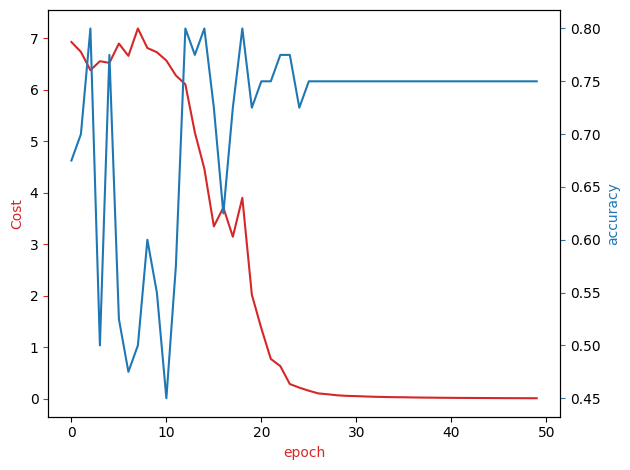

In [126]:
cl = torch.tensor(cost_list,device='cpu')
al = torch.tensor(acc_list,device='cpu')
# Plot the Loss and Accuracy vs Epoch graph
with torch.no_grad():
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(cl, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('Cost', color=color)
    ax1.tick_params(axis='y', color=color)
        
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color) 
    ax2.set_xlabel('epoch', color=color)
    ax2.plot( al, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()

In [127]:
# from pathlib import Path

# fol_path = Path("Classification")
# fol_path.mkdir(parents=True,exist_ok=True)
# name_model = "Tan_dep_trai.pth"

# model_path = fol_path/name_model

# torch.save(model.to("cpu").state_dict(),model_path)

In [128]:
# sample = pp('/content/m4.png')
# with torch.inference_mode():
#   kq = torch.squeeze(model(sample))
# print(kq)


In [129]:
# loc = []
# ep =0

# for x,y in test_data:
#   y_pred = torch.round(model(x))
#   y = y.reshape(-1,1).type(torch.float32)
#   print(acc_fn(y_pred,y))

  